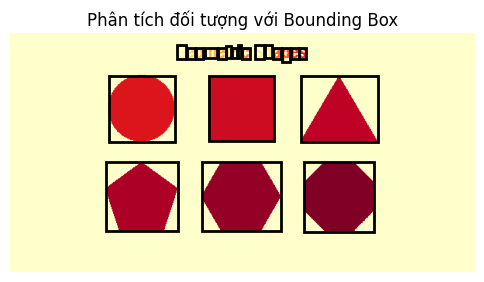

In [1]:
from PIL import Image  # Sửa từ PII thành PIL
import numpy as np
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu

# Mở ảnh và chuyển sang grayscale
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)

# Thực hiện phân ngưỡng Otsu
thres = threshold_otsu(a)
b = a > thres  # Tạo ảnh nhị phân

# Gán nhãn các vùng liên thông
c = label(b)

# Phân tích các thuộc tính vùng
regions = regionprops(c)

# Tạo figure để hiển thị
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(c, cmap='YlOrRd')  # Hiển thị ảnh đã gán nhãn

# Vẽ bounding box cho từng vùng
for region in regions:
    min_row, min_col, max_row, max_col = region.bbox
    width = max_col - min_col
    height = max_row - min_row
    
    # Tạo hình chữ nhật bao quanh đối tượng
    rect = mpatches.Rectangle(
        (min_col, min_row), 
        width, 
        height, 
        fill=False, 
        edgecolor='black', 
        linewidth=2
    )
    ax.add_patch(rect)

plt.title('Phân tích đối tượng với Bounding Box')
plt.axis('off')
plt.show()

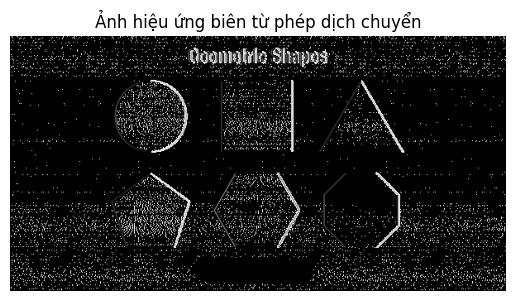

In [2]:
from PIL import Image
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

# Mở ảnh và chuyển sang grayscale
data = Image.open('geometric.png').convert('L')

# Chuyển ảnh thành mảng numpy
data_array = np.array(data)

# Tạo ảnh dịch chuyển 1 pixel sang phải
shifted = nd.shift(data_array, shift=(0, 1), mode='nearest')

# Tính toán sự khác biệt tuyệt đối giữa ảnh gốc và ảnh dịch chuyển
diff = np.abs(data_array - shifted)

# Hiển thị kết quả
plt.imshow(diff, cmap='gray')
plt.title('Ảnh hiệu ứng biên từ phép dịch chuyển')
plt.axis('off')
plt.show()

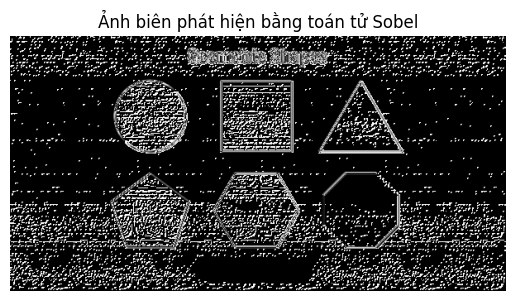

In [3]:
from PIL import Image
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

# Mở ảnh và chuyển sang grayscale
data = Image.open('geometric.png').convert('L')

# Chuyển ảnh thành mảng numpy
data_array = np.array(data)

# Tính toán đạo hàm theo hướng x (trục 0) bằng Sobel
sobel_x = nd.sobel(data_array, axis=0)

# Tính toán đạo hàm theo hướng y (trục 1) bằng Sobel
sobel_y = nd.sobel(data_array, axis=1)

# Kết hợp biên theo cả hai hướng
edge_magnitude = np.abs(sobel_x) + np.abs(sobel_y)

# Hiển thị kết quả
plt.imshow(edge_magnitude, cmap='gray')
plt.title('Ảnh biên phát hiện bằng toán tử Sobel')
plt.axis('off')
plt.show()

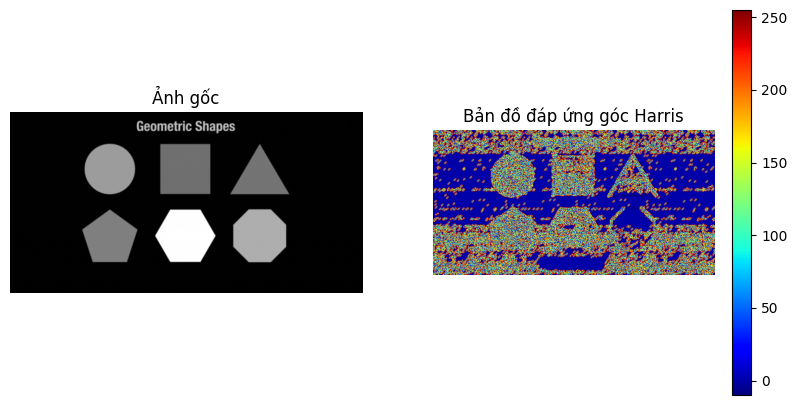

In [4]:
from PIL import Image
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

def Harris(indata, alpha=0.04):
    """
    Phát hiện góc bằng phương pháp Harris
    Args:
        indata: Ảnh đầu vào (grayscale)
        alpha: Tham số nhạy (thường từ 0.04 đến 0.06)
    Returns:
        Ma trận đáp ứng góc (corner response)
    """
    # Tính đạo hàm theo 2 hướng
    x = nd.sobel(indata, axis=0)
    y = nd.sobel(indata, axis=1)
    
    # Tính các thành phần của ma trận M
    x2 = nd.gaussian_filter(x**2, sigma=1)
    y2 = nd.gaussian_filter(y**2, sigma=1)
    xy = nd.gaussian_filter(x*y, sigma=1)
    
    # Tính toán corner response
    detM = x2 * y2 - xy**2
    traceM = x2 + y2
    R = detM - alpha * traceM**2
    
    return R

# Mở ảnh và chuyển sang grayscale
data = Image.open('geometric.png').convert('L')
data_array = np.array(data)

# Áp dụng phát hiện góc Harris
corner_response = Harris(data_array)

# Hiển thị kết quả
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(data_array, cmap='gray')
plt.title('Ảnh gốc'), plt.axis('off')

plt.subplot(122), plt.imshow(corner_response, cmap='jet')
plt.title('Bản đồ đáp ứng góc Harris'), plt.axis('off')
plt.colorbar()
plt.show()

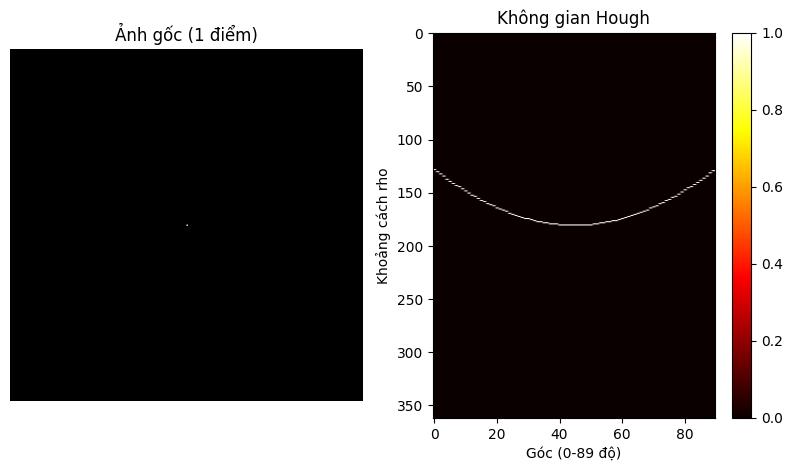

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def LineHough(data, gamma):
    """
    Thực hiện phép biến đổi Hough cho đường thẳng
    Args:
        data: Ảnh đầu vào (binary)
        gamma: Ngưỡng cường độ
    Returns:
        Không gian Hough (accumulator array)
    """
    V, H = data.shape
    R = int(np.sqrt(V**2 + H**2))  # Bán kính tối đa
    ho = np.zeros((R, 90), dtype=float)  # Không gian Hough
    
    w = data.copy()  # Tạo bản sao của ảnh đầu vào
    ok = True
    
    theta = np.arange(90) * (np.pi / 180)  # Chuyển đổi sang radian (0-89 độ)
    
    while ok:
        mx = w.max()
        if mx < gamma:
            ok = False
        else:
            # Tìm điểm có giá trị lớn nhất
            v, h = np.unravel_index(w.argmax(), w.shape)
            y = V - 1 - v  # Chuyển đổi hệ tọa độ
            x = h
            
            # Tính rho cho tất cả các góc theta
            rh = x * np.cos(theta) + y * np.sin(theta)
            
            # Cập nhật không gian Hough
            for i in range(90):
                r = int(round(rh[i]))
                if 0 <= r < R:
                    ho[r, i] += mx
            
            # Đặt giá trị điểm đã xử lý về 0
            w[v, h] = 0
    
    return ho

# Tạo ảnh test với một điểm trắng ở giữa
data = np.zeros((256, 256))
data[128, 128] = 1

# Áp dụng biến đổi Hough
hough_space = LineHough(data, gamma=0.5)

# Hiển thị kết quả
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(data, cmap='gray')
plt.title('Ảnh gốc (1 điểm)'), plt.axis('off')

plt.subplot(122), plt.imshow(hough_space, cmap='hot', aspect='auto')
plt.title('Không gian Hough'), plt.xlabel('Góc (0-89 độ)'), plt.ylabel('Khoảng cách rho')
plt.colorbar()
plt.show()

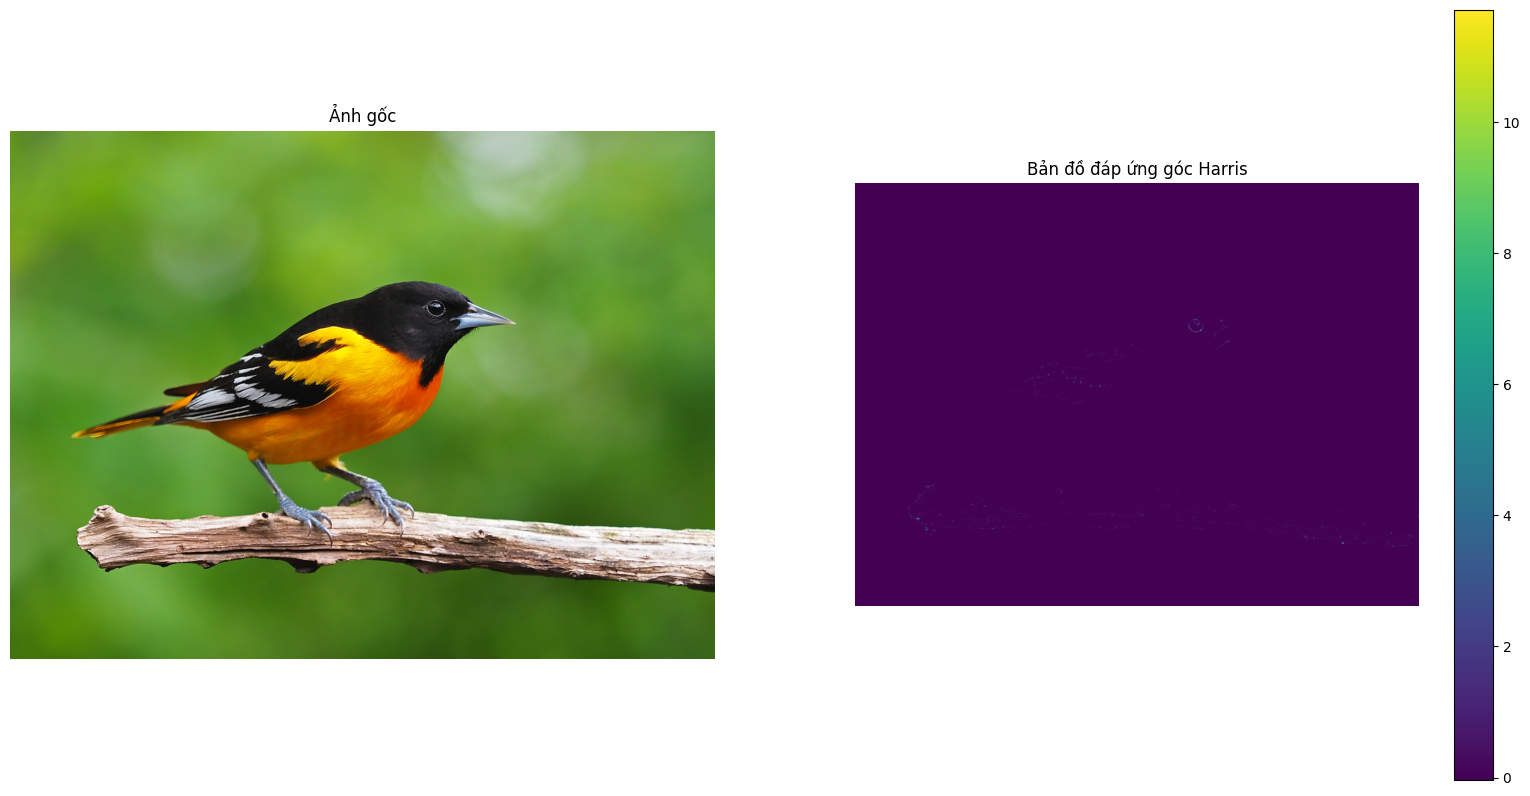

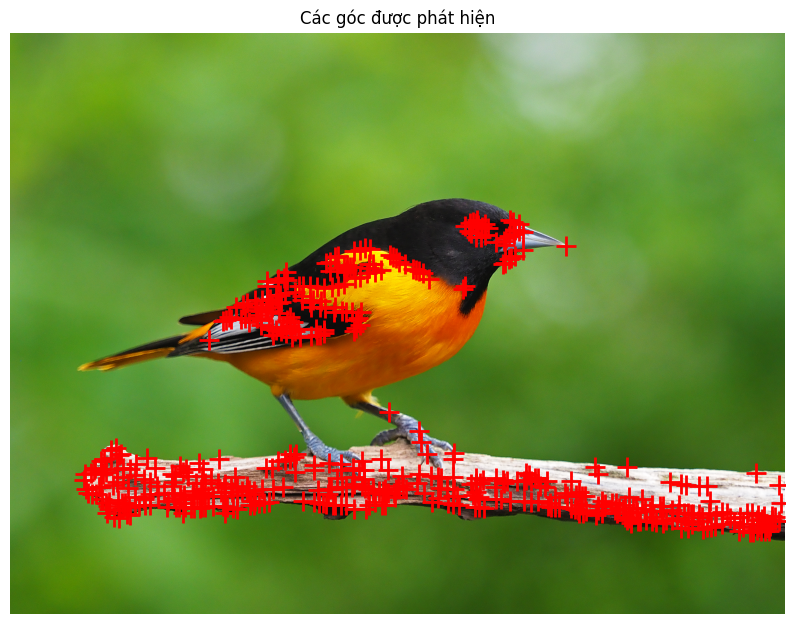

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris, corner_peaks
from skimage.color import rgb2gray

# Đọc ảnh và chuyển sang grayscale
data = plt.imread('bird.png')
image_gray = rgb2gray(data)

# Phát hiện góc bằng Harris Corner Detection
corner_response = corner_harris(image_gray, k=0.001)

# Tìm các đỉnh góc (peaks)
coords = corner_peaks(corner_response, min_distance=5, threshold_rel=0.02)

# Hiển thị kết quả
plt.figure(figsize=(20, 10))

# Hiển thị ảnh gốc
plt.subplot(121)
plt.imshow(data)
plt.title('Ảnh gốc')
plt.axis('off')

# Hiển thị bản đồ đáp ứng góc
plt.subplot(122)
plt.imshow(corner_response, cmap='viridis')
plt.title('Bản đồ đáp ứng góc Harris')
plt.colorbar()
plt.axis('off')

# Đánh dấu các góc được phát hiện trên ảnh gốc
plt.figure(figsize=(10, 10))
plt.imshow(data)
plt.plot(coords[:, 1], coords[:, 0], 'r+', markersize=15, mew=2)
plt.title('Các góc được phát hiện')
plt.axis('off')
plt.show()